In [ ]:
# create multiple QASM, derived by the one under study and modifying the current qasm 
# see whe

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append("../lib")
from utils import *
from utils import load_config_and_check
from utils import convert_single_program
from utils import run_single_program
from detectors import *
import os

In [4]:
CONFIG_PATH = "../config/dd_v00.yaml"
config = load_config_and_check(CONFIG_PATH)

In [5]:
# file to debug
file_to_debug = config["start_qasm_file"]
QASM_CONTENT = open(file_to_debug, 'r').read()
print("FILE: ", file_to_debug)
print("-" * 80)
print(QASM_CONTENT)

FILE:  ../data/experiment_v03/cross_platform/original_programs/32.qasm
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[9], q[6];
ry(0.9801424781769557) q[1];
cx q[8], q[5];
ry(6.094123332392967) q[0];
rz(1.1424399624340646) q[2];
cx q[3], q[5];
rx(3.844385118274953) q[2];
cx q[2], q[4];
rx(1.2545873742863833) q[7];
rx(0.29185655071471744) q[5];
ry(0.4087312132537349) q[1];
U(0,5.0793103400482895,0) q[9];
cx q[0], q[7];
rx(3.1112882860657196) q[1];
cx q[9], q[2];
ry(3.267683749398383) q[3];
rx(6.092079887237463) q[1];
rz(5.622366060669442) q[9];
ry(0.55601478868818) q[9];
cx q[0], q[3];
cx q[2], q[8];
cx q[2], q[5];
cx q[8], q[0];
U(0,1.24856745052169,0) q[7];
cx q[8], q[6];
rz(0.465236267850866) q[7];
cx q[1], q[8];
ry(0.39934889266571716) q[3];
cx q[3], q[7];
ry(2.9670138796084675) q[8];
cx q[7], q[6];
rx(3.1026092358267214) q[7];
rx(0.15971308367983456) q[4];
cx q[0], q[6];
cx q[5], q[9]

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
from qasm_manipulation import QasmModifier

In [33]:
qasm_modifier = QasmModifier(original_qasm=QASM_CONTENT)

In [34]:
qasm_modifier.get_available_lines()

[4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149]

In [63]:
test_list = [4,5,6,7,8,9,10,11,12,13,14,15, 16]

def partition_and_complement(input_list, n_partitions=3):
    """Divide a list in n_partitions, the remainder is added to the last."""
    partition_size = len(input_list) // n_partitions
    partitions = []
    complements = []
    for i in range(n_partitions - 1):
        # create i-th partition
        i_partition = input_list[
            i * partition_size: (i + 1) * partition_size
        ]
        partitions.append(i_partition)
        # create i-th complement 
        i_complement = input_list[:i * partition_size] + input_list[(i + 1) * partition_size:]
        complements.append(i_complement)
    # last i-th partition
    last_partition = input_list[
        (n_partitions - 1) * partition_size:
    ]
    partitions.append(last_partition)
    # last i-th complement
    last_complement = input_list[:(i + 1) * partition_size]
    complements.append(last_complement)
    partitions = partitions
    complements = complements
    return partitions, complements

deltas, namblas = partition_and_complement(test_list)
namblas

[[8, 9, 10, 11, 12, 13, 14, 15, 16],
 [4, 5, 6, 7, 12, 13, 14, 15, 16],
 [4, 5, 6, 7, 8, 9, 10, 11]]

In [99]:
from copy import deepcopy
import pdb


records = []


def delta_debugging(qasm_content, partitions, records, n_partitions=2):
    """Check if any of the partitions fails the test.
    
    Return:
    I returns either:
    - None, if no partition produce a failing test. Otherwise:
    - list[int], list of the lines of the partitions which induces failure.
    """
    qasm_modifier = QasmModifier(qasm_content)
    
    qasm_modifier_4_partitions = [
        deepcopy(qasm_modifier)
        for _ in partitions
    ]
    
    [
        q_modif.set_visible_only(partition_lines)
        for q_modif, partition_lines in zip(
            qasm_modifier_4_partitions, partitions)
    ]
    
    qasm_content_4_partitions = [
        q_modif.get_visible()
        for q_modif in qasm_modifier_4_partitions
    ]
    #pdb.set_trace()
    print("qasm_content_4_partitions:")
    [print(e + "\n\n\n\n") for e in qasm_content_4_partitions]
    
    for qasm, involved_lines in zip(qasm_content_4_partitions, partitions):
        print(f"TESTING PROGRAM WITH LINES: {involved_lines}")
        print("-" * 80)
        print(qasm)
        print("-" * 80)
        failure_inducing, stat, p_value = is_divergent(qasm_content=qasm, config=config, threshold=0.01)
        involved_lines 
        new_record = {
            "involved_lines": involved_lines,
            "statistic": stat,
            "p_value": p_value
        }
        records.append(new_record)
        if failure_inducing:
            print(f"FAILURE INDUCING PROGRAM FOUND with {len(involved_lines)} lines!")
            return involved_lines
        
    return None


qasm_modifier = QasmModifier(QASM_CONTENT)    
DELTA  = qasm_modifier.get_available_lines()

# first step
n = 2

SAFE_EXIT = 100

counter = 0

while True:
    if counter > SAFE_EXIT:
        raise Exception(f"MAX ITERATION REACHED {SAFE_EXIT}")
    print(f"ITERATION: {counter}")
    counter +=1

    # partition in different deltas
    deltas, nablas = partition_and_complement(
        input_list=DELTA,
        n_partitions=n
    )
    
    print("-" * 80)
    print("deltas:")
    print(deltas)
    print("-" * 80)
    print("nablas (complements):")
    print(nablas)
    print("-" * 80)
    

    # check deltas
    failing_lines = delta_debugging(qasm_content=QASM_CONTENT, partitions=deltas, records=records, n_partitions=n)
    if failing_lines is not None:
        DELTA = failing_lines
        n = 2
        print(f"FAIL DETECTED in delta: {failing_lines}")
        print(f"n = {n}")
        continue
    # if delta_i causes problem restart with DELTA = delta_i, and n=2

    # check nablas
    failing_lines = delta_debugging(qasm_content=QASM_CONTENT, partitions=nablas, records=records, n_partitions=n)
    if failing_lines is not None:
        DELTA = failing_lines
        n = n - 1
        print(f"FAIL DETECTED in complement: {failing_lines}")
        print(f"n = n - 1 = {n}")
        continue
    # if nabla_i causes problem restart with DELTA = nabla_i, and n= n -1

    # no failure
    # If the granularity is not yet at its maximum (n < size of Delta),
    if n < len(DELTA):
        DELTA = DELTA
        n = n * 2
        print(f"GRANULARITY NOT YET MAX: {n} < {len(DELTA)}")
        # n = n * 2, same DELTA
        continue
    else:
        print("SUCCESS: 1-minimal found: ")
        print(DELTA)
        break

print("PROCESS FINISHED")


df = pd.DataFrame.from_records(records)
df.to_csv("delta_debugging.csv")




ITERATION: 0
--------------------------------------------------------------------------------
deltas:
[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]
--------------------------------------------------------------------------------
nablas (complements):
[[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113

p_value:  0.09352892894698887
TESTING PROGRAM WITH LINES: [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
rz(3.5707882664211867) q[6];
cx q[3], q[2];
cx q[9], q[3];
U(0,4.99394670439314,0) q[6];
rx(3.09457993732866) q[5];
cx q[7], q[2];
cx q[6], q[1];
U(0,5.7482624946949334,0) q[9];
cx q[0], q[9];
cx q[9], q[8];
rz(2.4196403901798487) q[2];
rz(1.0649543356515678) q[3];
rx(4.373284191827385) q[9];
rx(3.864204370605488) q[0];
U(0,3.2567612560073336,0) q[1];
U(0,4.37947906269436,0) q[7];
ry(1.8446919621904219) q[3];
rz(5.447976052364645) q[8];
U(0,3.15111981408

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.7362882836586733
qasm_content_4_partitions:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[0], q[3];
cx q[9], q[7];
ry(5.0496205853630185) q[8];
cx q[8], q[4];
rz(1.9980747615752663) q[8];
cx q[2], q[4];
rz(0.04368152440717204) q[8];
rx(1.3955445313595205) q[4];
cx q[3], q[9];
cx q[5], q[7];
cx q[9], q[8];
c

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

p_value:  0.30102473544932307
TESTING PROGRAM WITH LINES: [49, 50, 51, 52, 53, 54, 55, 56, 57]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[5], q[7];
cx q[9], q[8];
cx q[4], q[2];
cx q[0], q[6];
rx(1.750787369989019) q[0];
U(0,0.9104013314092384,0) q[2];
rx(1.520878125486425) q[9];
ry(1.4931207248472882) q[7];
rz(3.9728947044295633) q[3];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --j

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.9205604093457642
TESTING PROGRAM WITH LINES: [94, 95, 96, 97, 98, 99, 100, 101, 102]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
rz(5.447976052364645) q[8];
U(0,3.15111981408976,0) q[5];
rz(4.4105879693123375) q[6];
rz(2.123686203

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

p_value:  0.9585827802903772
TESTING PROGRAM WITH LINES: [24, 25, 26, 27]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[2], q[8];
cx q[2], q[5];
cx q[8], q[0];
U(0,1.24856745052169,0) q[7];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already 

p_value:  0.982539202794787
TESTING PROGRAM WITH LINES: [44, 45, 46, 47]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
rz(1.9980747615752663) q[8];
cx q[2], q[4];
rz(0.04368152440717204) q[8];
rx(1.3955445313595205) q[4];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite

p_value:  0.9585827802903772
TESTING PROGRAM WITH LINES: [64, 65, 66, 67]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[1], q[9];
U(0,4.146802061014889,0) q[2];
rz(3.32789273186563) q[5];
cx q[0], q[9];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file i

p_value:  1.0
TESTING PROGRAM WITH LINES: [84, 85, 86, 87]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
U(0,5.7482624946949334,0) q[9];
cx q[0], q[9];
cx q[9], q[8];
rz(2.4196403901798487) q[2];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already

p_value:  1.0
TESTING PROGRAM WITH LINES: [104, 105, 106, 107]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[5], q[4];
ry(6.131459447659643) q[7];
rx(4.996302215442763) q[3];
cx q[4], q[0];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already 

p_value:  0.9999972952674809
TESTING PROGRAM WITH LINES: [124, 125, 126, 127]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[6], q[4];
rx(2.425954420893106) q[9];
U(0,1.2301919813841253,0) q[9];
cx q[1], q[0];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output 

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

p_value:  0.9999999999999997
TESTING PROGRAM WITH LINES: [24, 25, 26, 27]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[2], q[8];
cx q[2], q[5];
cx q[8], q[0];
U(0,1.24856745052169,0) q[7];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already 

p_value:  0.9585827802903772
TESTING PROGRAM WITH LINES: [44, 45, 46, 47]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
rz(1.9980747615752663) q[8];
cx q[2], q[4];
rz(0.04368152440717204) q[8];
rx(1.3955445313595205) q[4];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrit

p_value:  0.9999997843992762
TESTING PROGRAM WITH LINES: [64, 65, 66, 67]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[1], q[9];
U(0,4.146802061014889,0) q[2];
rz(3.32789273186563) q[5];
cx q[0], q[9];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file i

p_value:  1.0
TESTING PROGRAM WITH LINES: [88, 89, 90, 91]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
rz(1.0649543356515678) q[3];
rx(4.373284191827385) q[9];
rx(3.864204370605488) q[0];
U(0,3.2567612560073336,0) q[1];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite

p_value:  1.0
TESTING PROGRAM WITH LINES: [108, 109, 110, 111]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[9], q[7];
ry(1.0888403256868147) q[4];
cx q[2], q[5];
rz(1.7588765482722726) q[6];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it alread

p_value:  0.9999999917991426
TESTING PROGRAM WITH LINES: [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[6], q[0];
cx q[8], q[0];
rz(0.7424515087377991) q[2];
ry(5.513319262854466) q[6];
rz(1.7720754824967075) q[8];
cx q[7], q[8];
U(0,2.33745857065829,0) q[4];
rz(5.8481207527820835) q[3];
U(0,4.717862060733784,0) q[4];
rz(5.670907162201281) q[1];
rx(2.0109309507642283) q[8];
U(0,0.06809497254534375,0) q[3];
U(0,2.006306756090162,0) q[0];
U(0,3.6030165132363225,0) q[9];
ry(1.8422976126400672) q[4];
cx q[6], q[7];
rz(0.5730648466006386) q[7];
rx(3.452791799287315) q[0];
rx(2.204864050935961) q[8];
cx q[1], q[7];
ry(0.528458648415554) q[1];
ry(5.16389904909091) q[0];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert 

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: [104]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[5], q[4];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Languag

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: [109]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
ry(1.0888403256868147) q[4];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Q

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: [114]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
cx q[7], q[0];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Languag

p_value:  1.0
TESTING PROGRAM WITH LINES: [119]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
ry(0.2846534885560305) q[6];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Q

p_value:  0.9999999999999997
TESTING PROGRAM WITH LINES: [126]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
U(0,1.2301919813841253,0) q[9];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy!

p_value:  1.0
TESTING PROGRAM WITH LINES: [131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
ry(5.513319262854466) q[6];
rz(1.7720754824967075) q[8];
cx q[7], q[8];
U(0,2.33745857065829,0) q[4];
rz(5.8481207527820835) q[3];
U(0,4.717862060733784,0) q[4];
rz(5.670907162201281) q[1];
rx(2.0109309507642283) q[8];
U(0,0.06809497254534375,0) q[3];
U(0,2.006306756090162,0) q[0];
U(0,3.6030165132363225,0) q[9];
ry(1.8422976126400672) q[4];
cx q[6], q[7];
rz(0.5730648466006386) q[7];
rx(3.452791799287315) q[0];
rx(2.204864050935961) q[8];
cx q[1], q[7];
ry(0.528458648415554) q[1];
ry(5.16389904909091) q[0];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o outp

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  1.0
TESTING PROGRAM WITH LINES: []
--------------------------------------------------------------------------------
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
barrier q;
measure q -> c;
--------------------------------------------------------------------------------
Q-Convert - Quantum Language Converter

Usage

/home/paltenmo/.conda/envs/ML4Quantum/bin/python3: can't open file '../data/dd_v00/tmp/tmp_cirq.py': [Errno 2] No such file or directory


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
#SUCCESS: 1-minimal found: 
#[112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
#PROCESS FINISHED


In [76]:
minimal_set = [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
qasm_modifier = QasmModifier(QASM_CONTENT)
qasm_modifier.set_visible_only(minimal_set)
qasm_minimal = qasm_modifier.get_visible()

print(qasm_minimal)    


OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
creg c[10];
U(0,3.4831092377150936,0) q[7];
ry(1.556539713366733) q[4];
cx q[7], q[0];
cx q[0], q[1];
rz(2.979322035970566) q[7];
cx q[4], q[5];
cx q[4], q[3];
ry(0.2846534885560305) q[6];
cx q[6], q[4];
rz(1.0237471982717627) q[6];
cx q[6], q[0];
ry(3.6158108990909743) q[9];
cx q[6], q[4];
rx(2.425954420893106) q[9];
U(0,1.2301919813841253,0) q[9];
cx q[1], q[0];
cx q[6], q[0];
cx q[8], q[0];
barrier q;
measure q -> c;


In [91]:
import shutil
from pathlib import Path

def is_divergent(qasm_content, config, threshold=0.05):
    
    # clean the folder 
    shutil.rmtree(config["tmp_folder"])
    # make sure it existis
    Path(config["tmp_folder"]).mkdir(parents=True, exist_ok=True)
    
    
    res_circ = convert_and_run("cirq", qasm_content, config)
    res_qiskit = convert_and_run("qiskit", qasm_content, config)
    
    
    detector = KS_Detector()
    stat, p_value = detector.check(res_circ, res_qiskit)
    print("p_value: ", p_value)
    return p_value < threshold, stat, p_value
    
    
def convert_and_run(target_platform, qasm_content, config):
    """Run a program on a target platform."""
    tmp_folder = config["tmp_folder"]
    # create a real QASM file
    with open(os.path.join(tmp_folder, "tmp.qasm"), 'w') as f:
        f.write(qasm_content)
        f.close()
    # convert file with qconvert utility > platform.py
    out_program_name = convert_single_program(
        target_program=os.path.join(tmp_folder, "tmp.qasm"),
        dest_folder=tmp_folder,
        dest_format=target_platform,
        qconvert_path=config["qconvert_path"]
    )
    # run the platform.py
    res = run_single_program(
        target_file=out_program_name, 
        dest_folder=tmp_folder, 
        python_path=config["python_path"]
    )
    # get the output into a dictionary
    return res
    
    

In [93]:
p_values = []
for _ in range(100):
    _, _, p_val = is_divergent(qasm_content=QASM_CONTENT, config=config, threshold=0.005)
    p_values.append(p_val)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.9945926716286952
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

p_value:  0.036607186893664635
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destina

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.6996354687179152
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

p_value:  0.6252232286391919
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.1426043426418189
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

p_value:  0.30102473544932307
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinat

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.7720126462800398
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

p_value:  0.7720126462800398
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.10423872426690864
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinat

p_value:  0.2106117312437866
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.8689652815106905
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

p_value:  0.1426043426418189
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.19162747608137745
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinat

p_value:  0.23100441666637422
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinat

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

p_value:  0.8388233365451063
Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destinati

<AxesSubplot:ylabel='Count'>

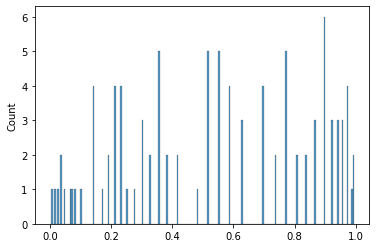

In [98]:
sns.histplot(p_values, bins=np.arange(0,1, .005))

In [2]:
import os

In [24]:
import re
register_name = 'q'
qubit_pos = 3
result = re.search(rf"\s*{register_name}\[\s*{qubit_pos}*\s*\]\s*", "rz(1.0649543356515678) q[3];")
result.group(0)

' q[3]'

In [22]:

result = re.search("q\[3\]", "q[3];")
type(result)

re.Match

In [104]:
# subtitute the number of shots
import re

injected_shot = 8192

# Pyquil
source_code = """
shots = 1024
"""
re.sub("= 1024", f'= {injected_shot}', source_code)

# Qiskit
source_code = """
shots = 1024
"""
re.sub("= 1024", f'= {injected_shot}', source_code)


# Cirq
source_code = """
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1024)
result_dict = dict(result.multi_measurement_histogram(keys=['c0', 'c1', 'c2', 'c3', 'c4']))
"""
re.sub("repetitions=1024\)", f"repetitions={injected_shot}\)", source_code)

"\nsimulator = cirq.Simulator()\nresult = simulator.run(circuit, repetitions=8192\\)\nresult_dict = dict(result.multi_measurement_histogram(keys=['c0', 'c1', 'c2', 'c3', 'c4']))\n"